# Back Propagation Neural Network from scratch using NumPy


## Overview
This notebook presents a hands-on approach to building a simple neural network from scratch using only `NumPy`, a fundamental library in Python known for its array operations and numerical computations. The focus is on understanding and manually implementing the core aspects of neural network training, including forward and backward propagation, without relying on higher-level frameworks like _TensorFlow_ or _PyTorch_.


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore", message="`sparse` was renamed to `sparse_output`")

## Load Data
We will use the Iris dataset, which is a simple and commonly used dataset for classification.

In [2]:
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  # Reshape for one-hot encoding

# One-hot encode targets
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Data Visualization
Visualize the Iris dataset features to understand the distributio

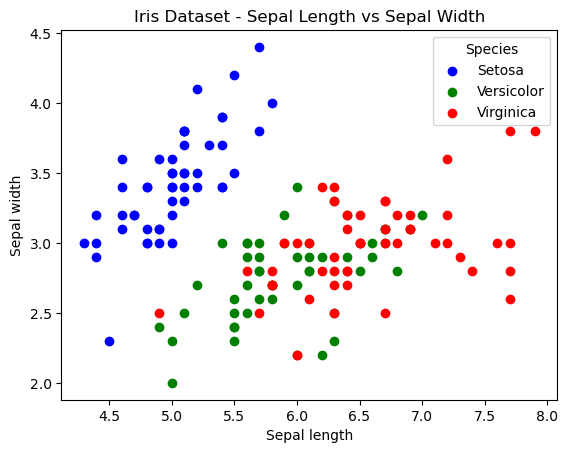

In [3]:
# Define colors and species labels
colors = ['blue', 'green', 'red']  
species = ['Setosa', 'Versicolor', 'Virginica']

y = np.array(y).flatten()

for idx, spec in enumerate(np.unique(y)):
    mask = y == spec
    plt.scatter(X[mask, 0], X[mask, 1], color=colors[idx], label=species[idx])

#Plot
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris Dataset - Sepal Length vs Sepal Width')
plt.legend(title='Species')
plt.show()

## Neural Network Implementation
We will implement a simple neural network with one hidden layer, using ReLU and Softmax activation functions, and backpropagation for learning.

#### 1. Parameter Initialization

- **Purpose**: Initialize network parameters (weights and biases) to small random values to prevent symmetry in learning.
- **Function**: `initialize_parameters(input_size, hidden_size, output_size)`
- **Details**:
  - `W1` and `W2`: Weight matrices for the hidden and output layers initialized with normal distribution scaled by 0.01.
  - `b1` and `b2`: Bias vectors initialized to zeros.
  - Ensures that each neuron in a layer learns different features during training by starting with different initial values.


In [4]:
def initialize_parameters(input_size, hidden_size, output_size):
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * 0.01
    b2 = np.zeros((output_size, 1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

#### 2. Activation Functions

- **ReLU (Rectified Linear Unit)**:
  - **Function**: `relu(Z)`
  - Provides non-linearity in the decision function, allowing the model to learn more complex patterns.
  - **Derivative**: `relu_derivative(Z)`, used during backpropagation to compute gradients.
- **Softmax**:
  - **Function**: `softmax(Z)`
  - Normalizes the output to a probability distribution over predicted output classes, suitable for multi-class classification tasks.


In [5]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

#### 3. Forward Propagation

- **Purpose**: Compute the output of the network for a given input `X`.
- **Function**: `forward_propagation(X, parameters)`
- **Operations**:
  - Linear transformations followed by activation functions (ReLU for hidden and Softmax for output layers).
  - Computes intermediate values `Z1`, `A1` (after ReLU), `Z2`, `A2` (after Softmax).


In [6]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

#### 4. Cost Function

- **Purpose**: Calculate the cross-entropy loss to evaluate the model's performance.
- **Function**: `compute_cost(A2, Y)`
- Measures the performance of the classification model whose output is a probability value between 0 and 1.


In [7]:
def compute_cost(A2, Y):
    m = Y.shape[1]
    cost = -np.sum(np.log(A2) * Y) / m
    return cost

#### 5. Backward Propagation

- **Purpose**: Compute gradients necessary for learning the parameters via gradient descent.
- **Function**: `backward_propagation(parameters, cache, X, Y)`
- **Details**:
  - `dZ2`, `dW2`, `db2`: Gradients of loss with respect to output layer's weights and biases.
  - `dZ1`, `dW1`, `db1`: Gradients of loss with respect to hidden layer's weights and biases.
  - Uses chain rule and derivatives of activation functions to propagate errors back through the network.


In [8]:
def backward_propagation(parameters, cache, X, Y):
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    m = Y.shape[1]
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(cache['Z1'])
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    gradients = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return gradients

#### 6. Update Parameters

- **Purpose**: Adjust the parameters (`W1`, `W2`, `b1`, `b2`) using the gradients computed in backward propagation.
- **Function**: `update_parameters(parameters, gradients, learning_rate)`
- Updates each parameter in the direction that minimally reduces the error (loss function).

In [9]:
def update_parameters(parameters, gradients, learning_rate):
    parameters['W1'] -= learning_rate * gradients['dW1']
    parameters['b1'] -= learning_rate * gradients['db1']
    parameters['W2'] -= learning_rate * gradients['dW2']
    parameters['b2'] -= learning_rate * gradients['db2']
    return parameters

#### 7. Model Training and Evaluation Functions

- **Model Training**:
  - Encapsulates initialization, forward and backward propagation, and parameter updates over multiple iterations.
- **Prediction and Accuracy Calculation**:
  - Uses the trained model to predict labels for new inputs and evaluates accuracy by comparing predicted labels to true labels.
- **Confusion Matrix and Precision-Recall-F1 Calculation**:
  - Further metrics to evaluate model performance, including confusion matrix, precision, recall, and F1 scores for each class.


In [10]:
def model(X, Y, input_size, hidden_size, output_size, num_iterations, learning_rate):
    parameters = initialize_parameters(input_size, hidden_size, output_size)
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        gradients = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, gradients, learning_rate)
    return parameters

#### 8. Function: `predict`

- **Purpose**: This function performs a forward pass using the trained network parameters and computes the output predictions for the input data `X`.
- **Parameters**:
  - `X`: The input features array.
  - `parameters`: A dictionary containing the trained weights and biases of the neural network.
- **Process**:
  - **Forward Pass**: Utilizes the `forward_propagation` function, which performs the entire sequence of computations from the input layer through hidden layers to the output layer.
  - **Softmax Output**: The final layer's activations (`A2`) are passed through a softmax function during the forward pass, which outputs probability distributions over the classes.
  - **Prediction**: The function uses `np.argmax` on `A2` across the first dimension (`axis=0`) to determine the index of the highest probability in each column, which corresponds to the class label prediction.
- **Returns**:
  - `predictions`: An array of predicted class labels for each example in `X`.

In [11]:
def predict(X, parameters):
    """ Perform a forward pass using trained parameters and return the predicted labels. """
    _, cache = forward_propagation(X, parameters)
    predictions = np.argmax(cache['A2'], axis=0)
    return predictions

#### 9. Function: `accuracy`

- **Purpose**: Calculate the accuracy of the predicted labels against the true labels.
- **Parameters**:
  - `predictions`: The array of predicted labels returned from the `predict` function.
  - `labels`: The actual true labels against which predictions are to be evaluated. These labels are typically in a one-hot encoded format.
- **Process**:
  - **Label Conversion**: Converts the one-hot encoded `labels` array into integer class labels using `np.argmax(labels, axis=0)`, which finds the class with the highest probability (true class) for each example.
  - **Accuracy Computation**: Computes the mean of the boolean values where predicted labels match the true labels (`predictions == labels`). The `np.mean` function calculates the fraction of correct predictions, effectively giving the model's accuracy.
- **Returns**:
  - The accuracy as a float, representing the percentage of correctly predicted labels.

In [12]:
def accuracy(predictions, labels):
    """ Calculate the accuracy of predictions by comparing to the true labels. """
    labels = np.argmax(labels, axis=0)  # Convert one-hot encoded labels back to single digit labels
    return np.mean(predictions == labels)

#### 10. Function: `store_updates`

- **Purpose**: Collects and stores the norms of the weights and biases as well as their gradient norms at a given iteration. This is useful for monitoring and debugging the training process.
- **Parameters**:
  - `iteration`: The current iteration number in the training loop.
  - `parameters`: A dictionary of the current weights (`W1`, `W2`) and biases (`b1`, `b2`) of the network.
  - `gradients`: A dictionary of the gradients (`dW1`, `dW2`, `db1`, `db2`) computed during the backward propagation step.
- **Process**:
  - **Norm Calculation**: Computes the Frobenius norm (default norm for matrices in `numpy.linalg.norm`) for each parameter and its corresponding gradient. This measure helps in understanding the magnitude of parameters and their rate of change.
  - **Data Structuring**: Organizes these norms into a dictionary, with keys indicating the parameter or gradient name followed by '_norm' or '_grad_norm' and the value being the calculated norm.
  - **Iteration Recording**: Adds the current iteration number to the dictionary for tracking purposes.
- **Returns**:
  - `update_info`: A dictionary containing the norms of parameters, their gradient norms, and the iteration number.


In [13]:
def store_updates(iteration, parameters, gradients):
    update_info = {}
    for key in parameters:
        update_info[key + "_norm"] = np.linalg.norm(parameters[key])
        update_info[key + "_grad_norm"] = np.linalg.norm(gradients['d' + key])
    update_info['iteration'] = iteration
    return update_info

#### 11. Function: `model`

- **Purpose**: Executes the full training cycle of the neural network, including forward and backward propagation, parameter updates, and periodically evaluating the model on a validation dataset.
- **Parameters**:
  - `X`, `Y`: Training dataset features and labels.
  - `X_val`, `Y_val`: Validation dataset features and labels.
  - `input_size`, `hidden_size`, `output_size`: Dimensions for the input layer, hidden layer, and output layer, respectively.
  - `num_iterations`: Total number of iterations for training the model.
  - `learning_rate`: Step size at each iteration for updating the parameters.
- **Process**:
  - **Initialization**: Parameters are initialized using `initialize_parameters`.
  - **Training Loop**:
    - **Forward Propagation**: Calculates network outputs for the training data.
    - **Cost Calculation**: Computes the cross-entropy cost, which guides the optimization.
    - **Backward Propagation**: Calculates gradients of the cost with respect to parameters.
    - **Parameter Update**: Adjusts the network parameters based on gradients.
    - **Validation Evaluation**: Every 100 iterations, the function evaluates the model's performance on the validation set using the `predict` and `accuracy` functions.
  - **Monitoring**: Stores updates on parameter norms and validation accuracy for monitoring progress.
- **Returns**:
  - `parameters`: The trained network parameters.
  - `updates`: A list of dictionaries detailing the parameter norms and gradient norms at specified intervals.
  - `accuracy_records`: A list of dictionaries containing accuracy measurements on the validation set at specified intervals.

In [14]:
def model(X, Y, X_val, Y_val, input_size, hidden_size, output_size, num_iterations, learning_rate):
    parameters = initialize_parameters(input_size, hidden_size, output_size)
    updates = []
    accuracy_records = []
    
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        gradients = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        if i % 100 == 0:  # Store updates every 100 iterations
            updates.append(store_updates(i, parameters, gradients))
            # Evaluate model on validation set
            predictions = predict(X_val, parameters)
            acc = accuracy(predictions, Y_val)
            accuracy_records.append({'iteration': i, 'accuracy': acc})
    
    return parameters, updates, accuracy_records

# Model Training
X_val, Y_val = X_test.T, Y_test.T
trained_parameters, update_records, accuracy_records = model(X_train.T, Y_train.T, X_val, Y_val, input_size=4, hidden_size=5, output_size=3, num_iterations=1000, learning_rate=0.01)

#### 12. Model Training
- **Validation Setup**: Assumes `X_test` and `Y_test` are defined and uses these as the validation dataset (`X_val`, `Y_val`).
- **Training Execution**: The model is trained using the training set and periodically evaluated using the validation set to monitor performance and avoid overfitting.


In [15]:
X_val, Y_val = X_test.T, Y_test.T
trained_parameters, update_records, accuracy_records = model(X_train.T, Y_train.T, X_val, Y_val, input_size=4, hidden_size=5, output_size=3, num_iterations=1000, learning_rate=0.01)

# Visualization: Model Accuracy over Iterations

- **X-axis**: Represents the training iterations, indicating the points in training at which the model's accuracy is evaluated.
- **Y-axis**: Shows the accuracy percentage, providing a measure of how well the model predicts the correct classifications on the validation set at each recorded iteration.
- **Line Plot**: The line connecting the data points demonstrates the trend of accuracy improvement or fluctuations throughout the training process.


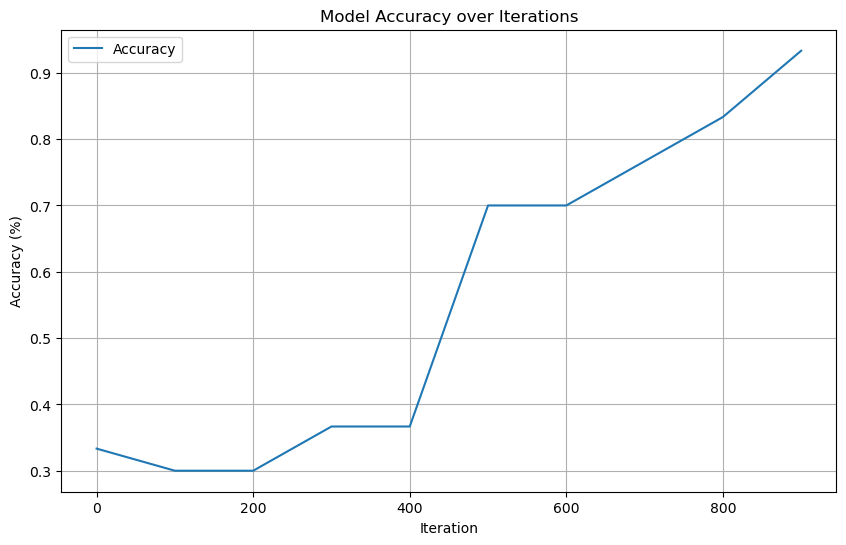

In [16]:
df_updates = pd.DataFrame(update_records)
df_accuracy = pd.DataFrame(accuracy_records)


# Plotting model accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_accuracy['iteration'], df_accuracy['accuracy'], label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Parameter and Gradient Norms over Iterations

- **Chart Overview**: This chart visualizes the norms of network parameters and their gradients throughout the training process, showing the magnitude changes over iterations.
- **X-axis**: Represents the training iterations, capturing the points in training where the norms are computed and recorded.
- **Y-axis**: Displays the norms of the parameters and gradients, providing insight into the scale of parameter values and the rate at which they are updated.
- **Line Plot**: Each line on the plot corresponds to a different parameter or gradient, with variations in the line styles or colors distinguishing between them.
- **Purpose of Visualization**: Helps in monitoring the training dynamics, specifically the magnitude of updates to parameters and gradients, which can inform adjustments to learning rates or highlight potential issues like vanishing or exploding gradients.

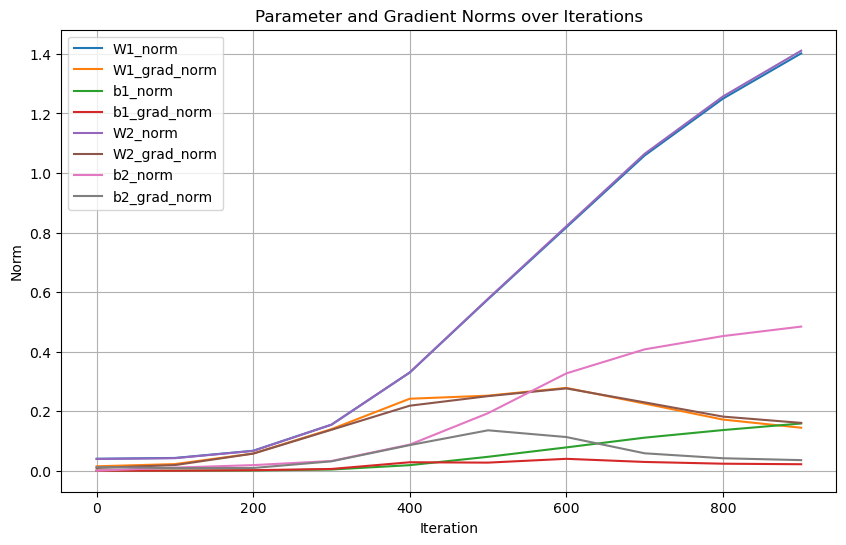

In [17]:
# Plotting parameter norms
plt.figure(figsize=(10, 6))
for column in df_updates.columns:
    if "norm" in column:
        plt.plot(df_updates['iteration'], df_updates[column], label=column)
plt.xlabel('Iteration')
plt.ylabel('Norm')
plt.title('Parameter and Gradient Norms over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Model Performance metrics

- **Model Accuracy**: Represents the overall percentage of correct predictions made by the model on the test set. This single metric provides a quick snapshot of model effectiveness.
- **Confusion Matrix**: A tabular representation that shows the actual versus predicted classifications for each class. It helps identify which classes are most frequently confused with others, indicating areas where the model may require improvement.
- **Precision, Recall, and F1-Score**: These metrics provide a deeper dive into the model's performance by class:
  - **Precision**: The ratio of true positive predictions to the total predicted positives, indicating the accuracy of positive predictions.
  - **Recall**: The ratio of true positive predictions to the actual positives, showing the model's ability to detect positive instances.
  - **F1-Score**: The harmonic mean of precision and recall, providing a single metric that balances both the precision and recall, which is particularly useful when the class distribution is uneven.
- **Class Labels**: Each metric is reported per class (Setosa, Versicolor, Virginica), which provides insights into the model's performance on specific types of iris flowers.

The combination of overall accuracy with precision, recall, and F1-score for each class offers a comprehensive view of the model's performance, highlighting strengths and pinpointing areas for potential refinement.

In [19]:
test_predictions = predict(X_test.T, trained_parameters)
test_accuracy = accuracy(test_predictions, Y_test.T)

print(f"Model Accuracy on Test Set: {test_accuracy * 100:.2f}%")

def confusion_matrix(predictions, labels):
    K = len(np.unique(labels))  # Number of classes
    conf_matrix = np.zeros((K, K), dtype=int)

    for i in range(len(labels)):
        conf_matrix[labels[i]][predictions[i]] += 1

    return conf_matrix

def precision_recall_f1(conf_matrix):
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1_scores = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_scores

true_labels = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(test_predictions, true_labels)
precision, recall, f1_scores = precision_recall_f1(conf_matrix)

metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_scores
})

class_labels = ['Setosa', 'Versicolor', 'Virginica']
metrics_df.index = class_labels

print("Confusion Matrix:\n", pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels))
print("\nMetrics per class:")
metrics_df

Model Accuracy on Test Set: 96.67%
Confusion Matrix:
             Setosa  Versicolor  Virginica
Setosa          10           0          0
Versicolor       0           8          1
Virginica        0           0         11

Metrics per class:


,Precision,Recall,F1-Score
Setosa,1.000000,1.000000,1.000000
Versicolor,1.000000,0.888889,0.941176
Virginica,0.916667,1.000000,0.956522
